In [1]:
import torch
import gpytorch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from gpytorch.priors import NormalPrior

from tqdm.notebook import tqdm

# Dumbbell

In [2]:
def get_line(name, fs):
    while True:
        try:
            line = next(fs)
        except StopIteration:
            return

        if name in line:
            try:
                next(fs)
            except StopIteration:
                return

            while True:
                try:
                    line = next(fs)
                except StopIteration:
                    return

                if line in ["\n", "\r\n"]:
                    break
                else:
                    yield line
        elif not line:
            break


def get_data(file_path, *args):
    M = {}
    for var in args:
        with open(file_path) as fs:
            g = get_line(var, fs)
            M[var] = np.loadtxt(g)

    return M

def groundtruth_from_samples(vertices, edges):
    import networkx as nx
    import numpy as np

    graph = nx.Graph()

    # add nodes
    for i in range(vertices.shape[0]):
        graph.add_node(i, pos=(vertices[i, 0], vertices[i, 1]))

    # edges
    for i in range(edges.shape[0]):
        graph.add_edge(edges[i, 0], edges[i, 1], length=np.linalg.norm(vertices[edges[i, 0], :]-vertices[edges[i, 1], :]))

    # geodesics
    geodesics = nx.shortest_path_length(graph, source=0, weight='length')

    # function
    period = 1.5
    phase = 0.0
    truth = np.zeros((vertices.shape[0]))
    #for i in range(truth.shape[0]):
        #truth[i] = 2 * np.sin(geodesics.get(i) * period + phase)

    return truth, geodesics

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
seed = 226
num_train = 100
num_test = 500

In [5]:
data_path = 'dumbbell.msh'
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

normalize_features = False
normalize_labels = False

In [6]:
input_data_dim = sampled_x.size(-1)

In [7]:
def create_data(seed, num_train, num_test, sampled_x, sampled_y):
    torch.manual_seed(seed)
    (m, n) = sampled_x.shape
    rand_idx = torch.randperm(m)
    train_idx = rand_idx[:num_train]
    train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]

    noise_train_x = 0.0
    train_x += noise_train_x * torch.randn(num_train, n)
    noise_train_y = 0.001
    train_y += noise_train_y * torch.randn(num_train)

    test_idx = rand_idx[num_train:num_train+num_test]
    test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

    noise_test_x = 0.0
    test_x += noise_test_x * torch.randn(num_test, n)
    noise_test_y = 0.0
    test_y += noise_test_y * torch.randn(num_test)

    if normalize_features:
        mu_x, std_x = train_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
        sampled_x.sub_(mu_x).div_(std_x)
        train_x.sub_(mu_x).div_(std_x)
        test_x.sub_(mu_x).div_(std_x)

    if normalize_labels:
        mu_y, std_y = train_y.mean(), train_y.std()
        train_y.sub_(mu_y).div_(std_y)
        test_y.sub_(mu_y).div_(std_y)
        sampled_y.sub_(mu_y).div_(std_y)
        
    sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    #use_cuda = torch.cuda.is_available()
    #device = torch.device("cuda" if use_cuda else "cpu")
    sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)
    train_x, train_y = train_x.to(device), train_y.to(device)
    test_x, test_y = test_x.to(device), test_y.to(device)

    if normalize_features:
        mu_x, std_x = mu_x.to(device), std_x.to(device)
        
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=train_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
        fig.colorbar(plot)
        ax.axis('equal')
        ax.set_title(f'Ground Truth Training Data of {num_train} points')
    
    return train_x, train_y, test_x, test_y, sampled_x, sampled_y

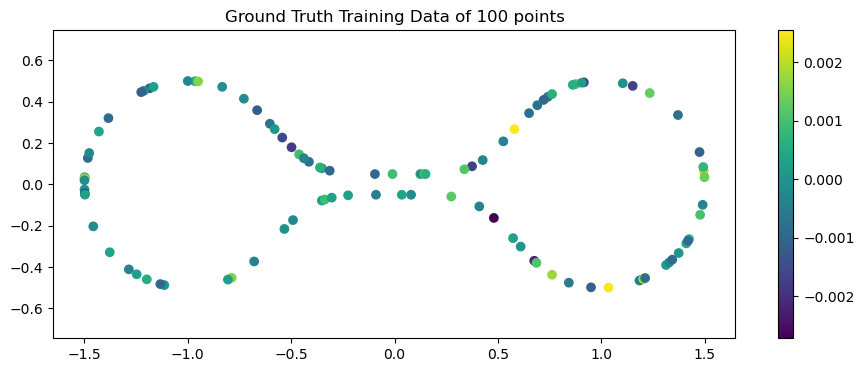

In [8]:
train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, num_train, num_test, sampled_x, sampled_y)

## Deep Kernel Learning

### Feature Extractor 

$K (x, y) = \kappa(\phi(x), \phi(y))$, where we are trying to estimate $\phi$ using an NN for our kernel!

In [8]:
class KernelMapper(torch.nn.Sequential):
    def __init__(self, input_data_dim):
        super(KernelMapper, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_data_dim, 32))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(32, 64))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(64, 128))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(128, 256))

### GP Regression

In [9]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, kernel_map):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=256))
            self.kernel_mapper = kernel_map

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through aN NN
            projected_x = self.kernel_mapper(x)
            projected_x = self.scale_to_bounds(projected_x)

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Combined Pipeline: Training and Evaluation

In [10]:
def get_result(train_x, train_y, test_x, test_y, training_iterations, learning_rate=0.0001):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    kernel_map = KernelMapper(input_data_dim)
    model = GPRegressionModel(train_x, train_y, likelihood, kernel_map)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.kernel_mapper.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)


    print('Test RMSE: {}'.format(torch.sqrt(torch.mean(torch.square(preds.mean - test_y)))))
    
    return model, preds

In [15]:
model, preds = get_result(train_x, train_y, test_x, test_y, 2)

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00014297218876890838


### Plots

In [11]:
def get_plot(nt, predictions, test_x, test_y, model, show_mean=True, show_stdev=True, posterior_only=False):
    with torch.no_grad():
        if show_mean:
            if not posterior_only:
                fig = plt.figure(figsize=(11, 4))
                ax = fig.add_subplot(111)
                plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c = test_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
                fig.colorbar(plot)
                ax.axis('equal')
                ax.set_title(f'Ground Truth with Noise ({nt} training points)')

            posterior_mean = predictions.mean.cpu().numpy()
            fig = plt.figure(figsize=(11, 4))
            ax = fig.add_subplot(111)
            plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c=posterior_mean)
            if not posterior_only:
                ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='r', s=1.0)
            fig.colorbar(plot)
            ax.axis('equal')
            ax.set_title(f'Posterior Mean ({nt} training points)')
        
        if show_stdev:
            if not posterior_only:
                """prior_std = model.covar_module(test_x, test_x, diag=True).sqrt()
                fig = plt.figure(figsize=(11, 4))
                ax = fig.add_subplot(111)
                plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c = prior_std.cpu().numpy())
                ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='r', s=0.5)
                fig.colorbar(plot)
                ax.axis('equal')
                ax.set_title(f'Prior Standard Deviation ({nt} training points)')"""

            posterior_std = predictions.stddev
            fig = plt.figure(figsize=(11, 4))
            ax = fig.add_subplot(111)
            plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c = posterior_std.cpu().numpy())
            if not posterior_only:
                ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='r', s=0.5)
            fig.colorbar(plot)
            ax.axis('equal')
            ax.set_title(f'Posterior Standard Deviation ({nt} training points)')

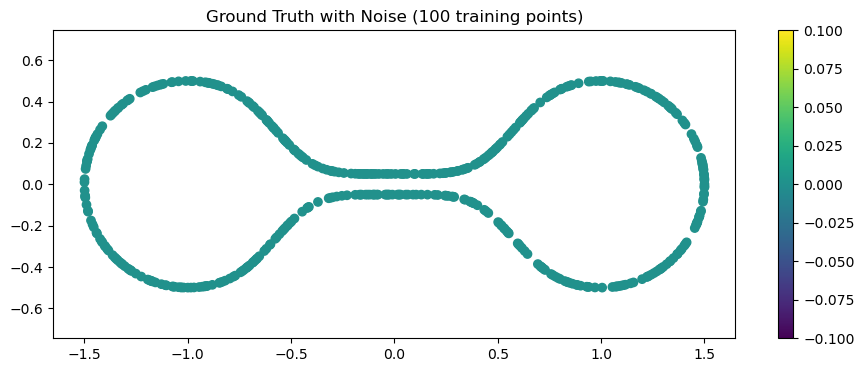

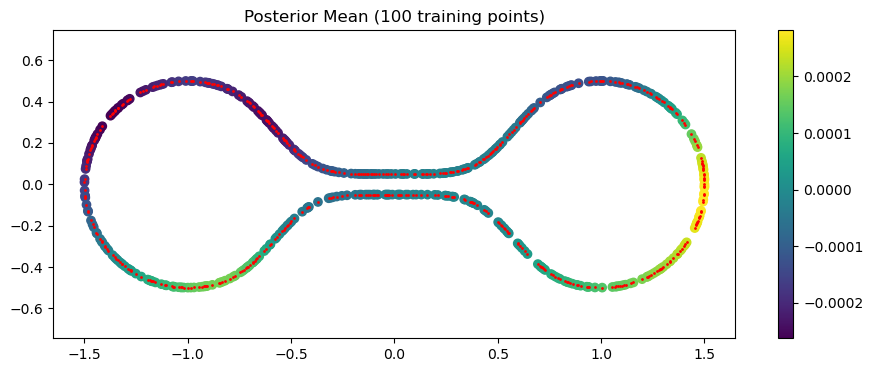

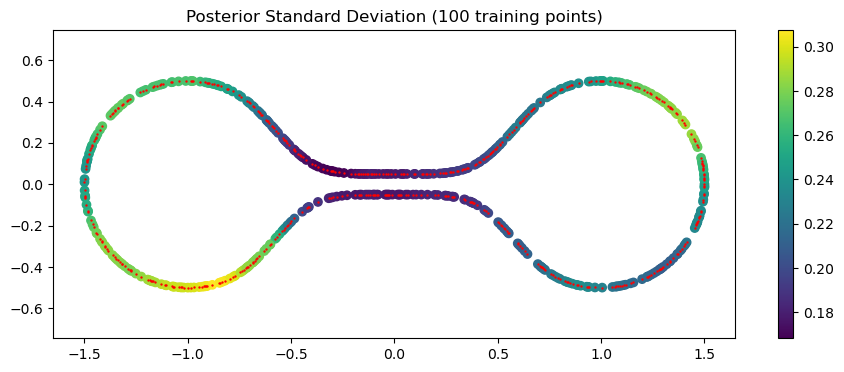

In [17]:
get_plot(num_train, preds, test_x, test_y, model)

### Comparison

In [18]:
num_test = 1000

nums_train = [50, 100, 200]

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00032123122946359217


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00022971043654251844


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00020127005700487643


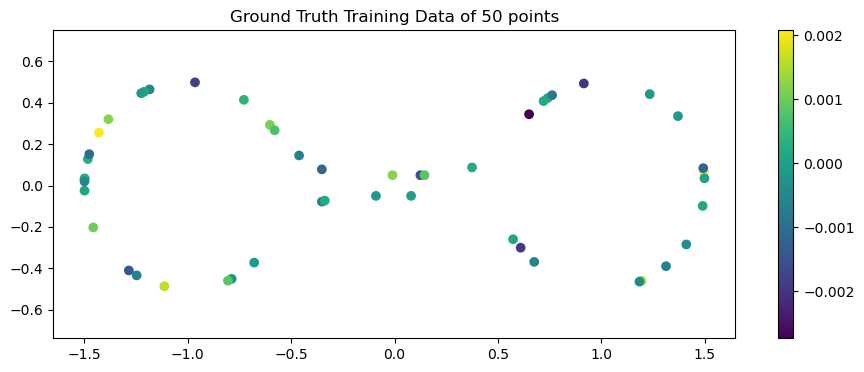

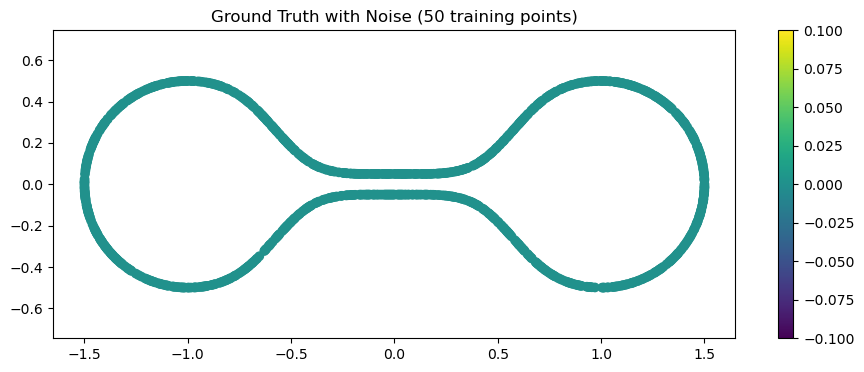

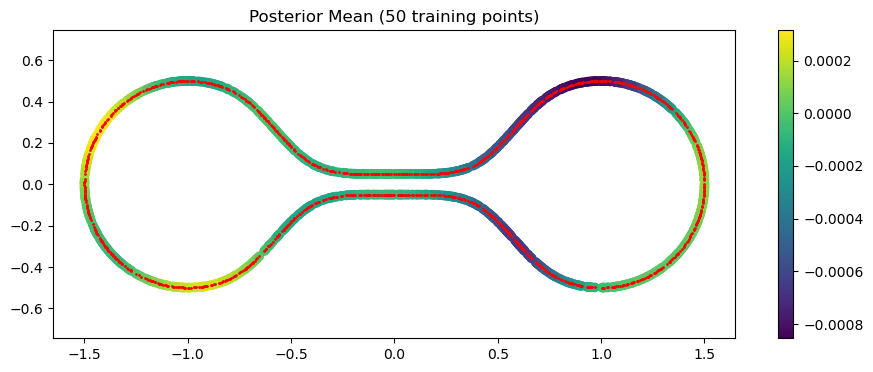

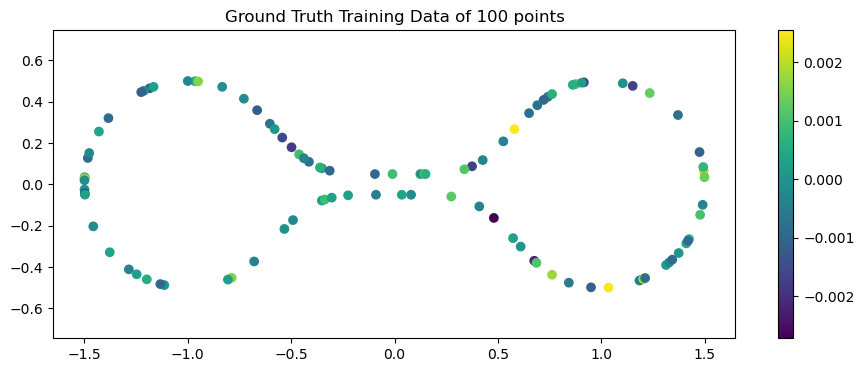

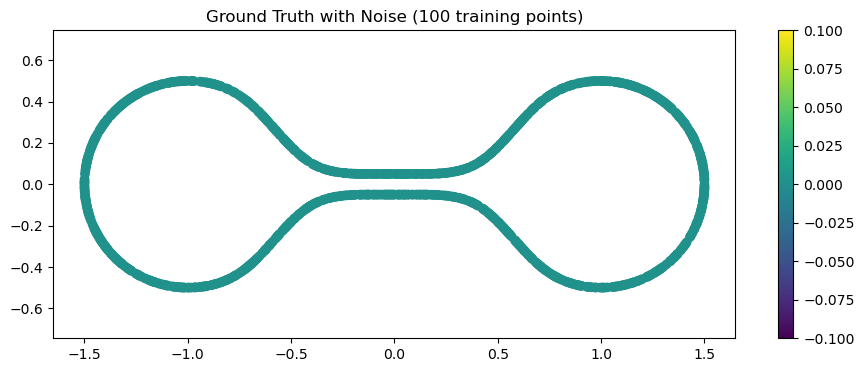

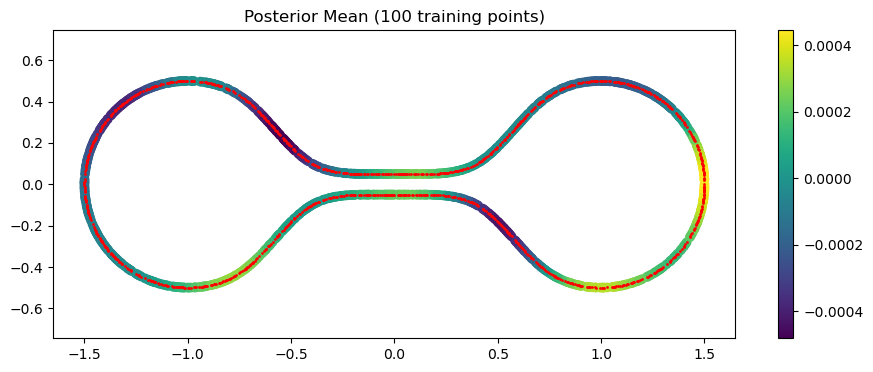

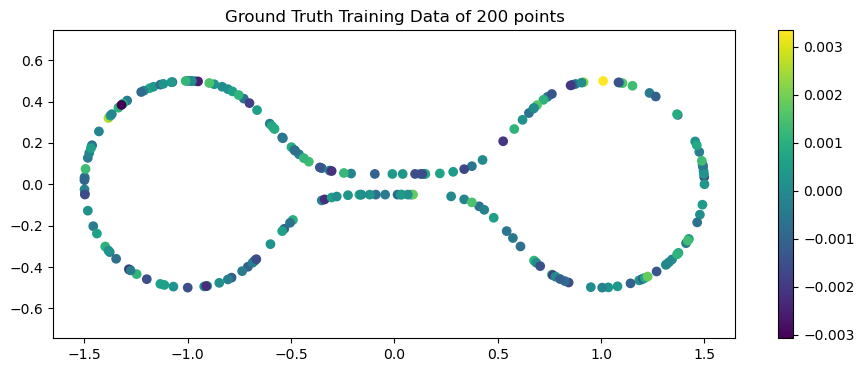

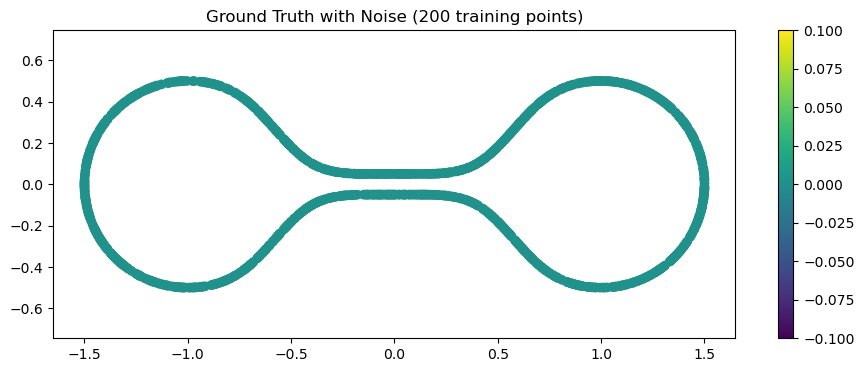

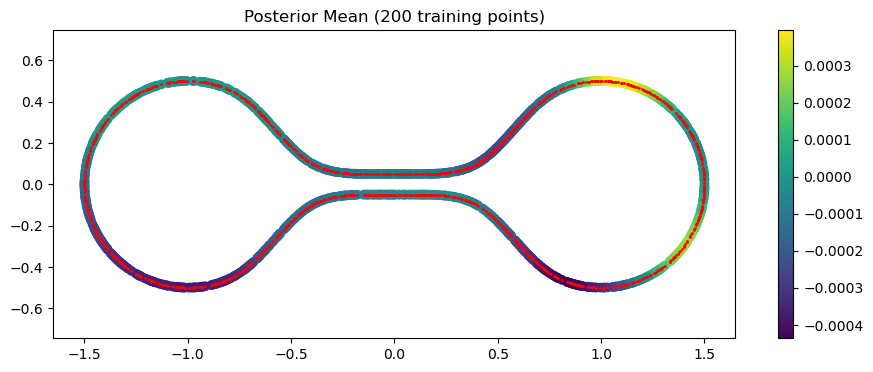

In [19]:
for nt in nums_train:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 2)
    get_plot(nt, preds, test_x, test_y, model, show_stdev=False)

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00032123122946359217


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00022971043654251844


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00020127005700487643


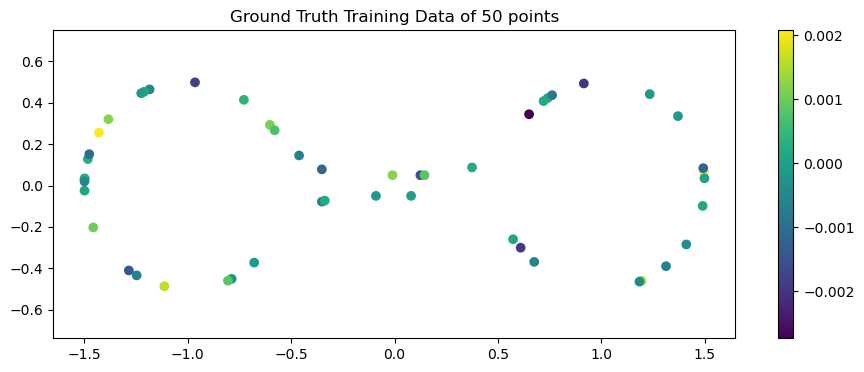

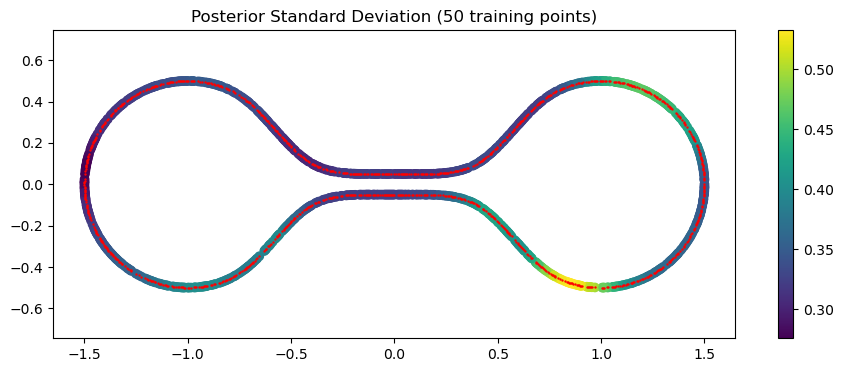

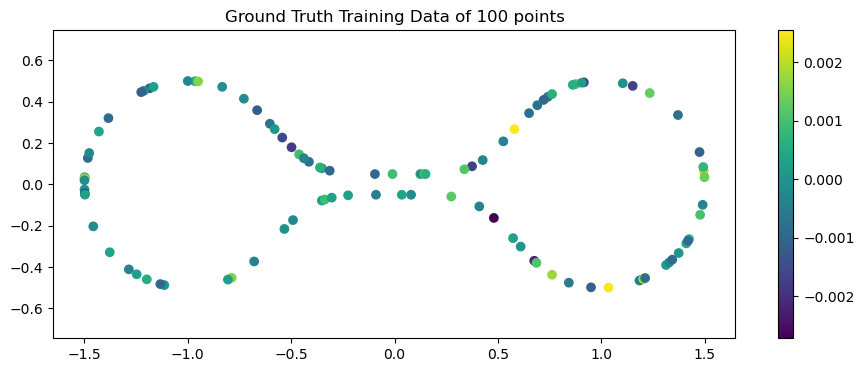

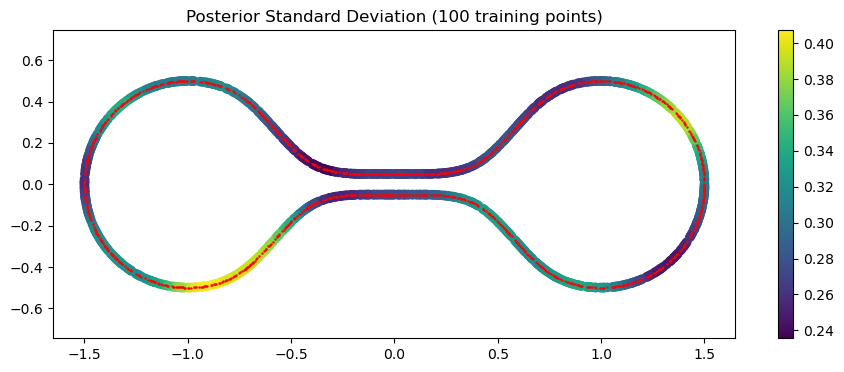

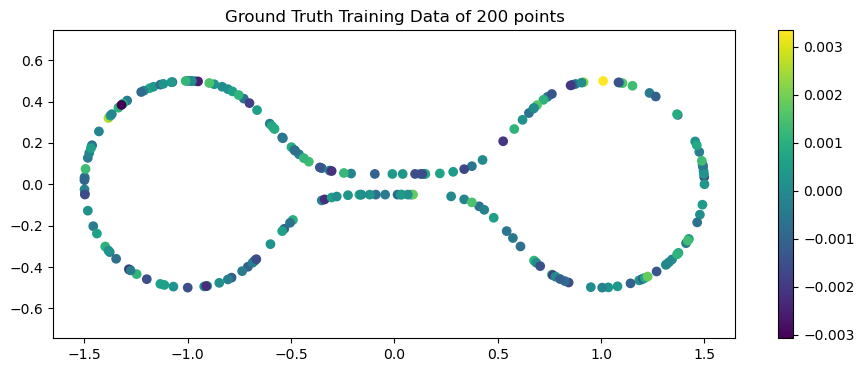

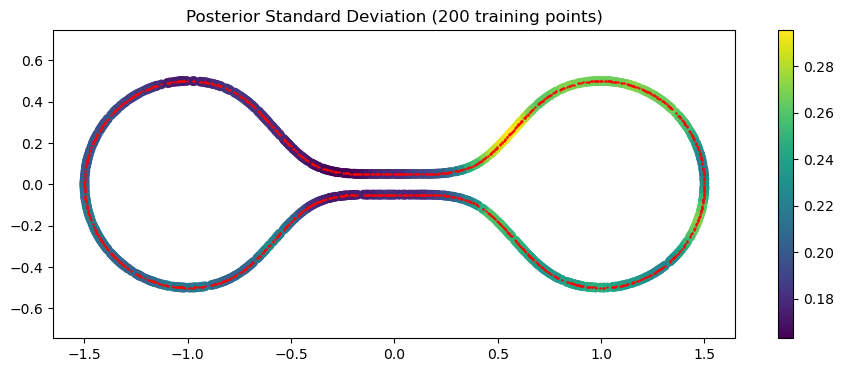

In [20]:
for nt in nums_train:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 2)
    get_plot(nt, preds, test_x, test_y, model, show_mean=False)

### Generating Grid for Surface

In [12]:
def create_grid(sampled, eps=0.1, res=0.01):
    dims = len(sampled.shape)
    
    borders = torch.empty((dims, 2), dtype=torch.float32)
    for i in range(dims):
        borders[i, 0] = min(sampled[:,i]) - eps
        borders[i, 1] = max(sampled[:,i]) + eps
        
    grid_sizes = torch.empty(dims, dtype=torch.int32)
    for i in range(dims):
        grid_sizes[i] = (borders[i, 1] - borders[i, 0])/res + 1
        
    grid_points = torch.empty((torch.prod(grid_sizes).int(), 2), dtype=torch.float32)
    if (dims==2):
        for x in range(grid_sizes[0]):
            for y in range(grid_sizes[1]):
                index = (x * grid_sizes[1]) + y
                grid_points[index] = torch.Tensor([borders[0, 0] + x * res, borders[1, 0] + y * res])
    return grid_points, grid_sizes

In [22]:
grid_points, grid_sizes = create_grid(sampled_x, res=0.01)
grid_points = grid_points.to(device)

### Comparison in Grid Points

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00032123122946359217


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00022971043654251844


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00020127005700487643


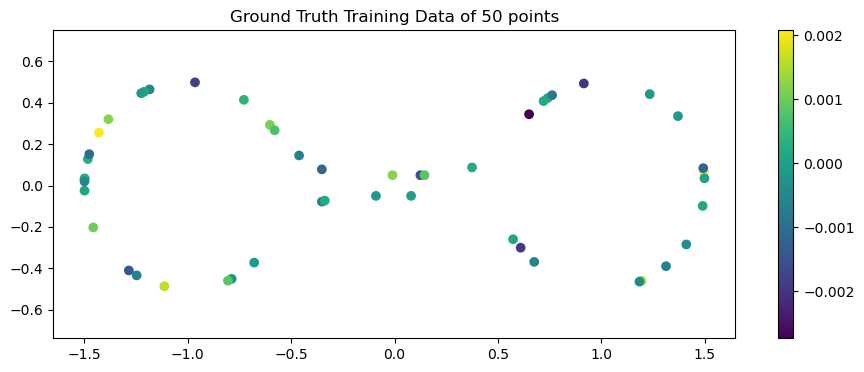

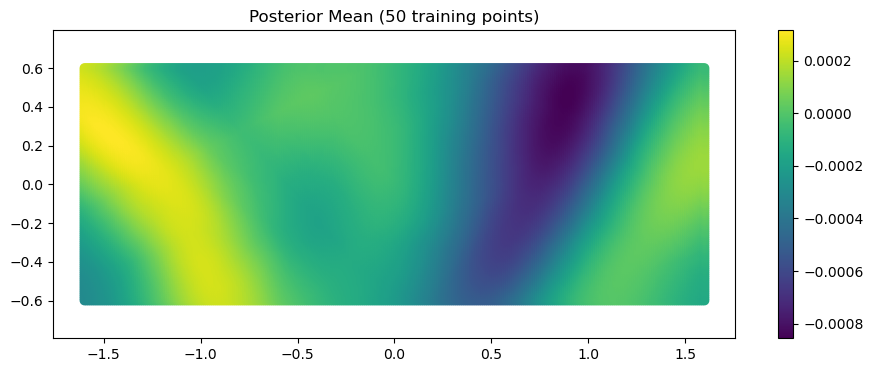

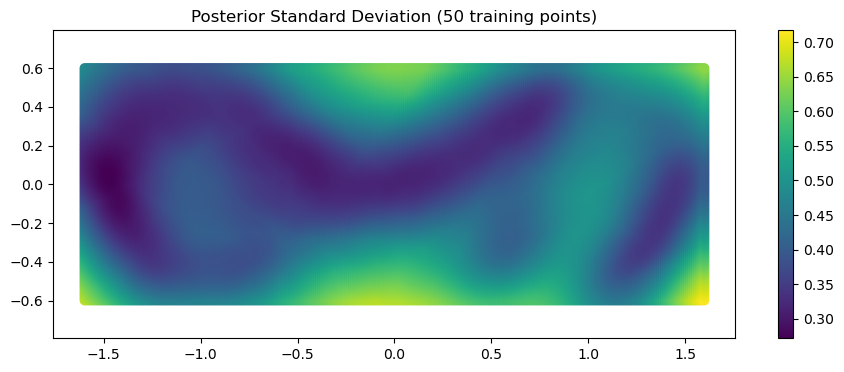

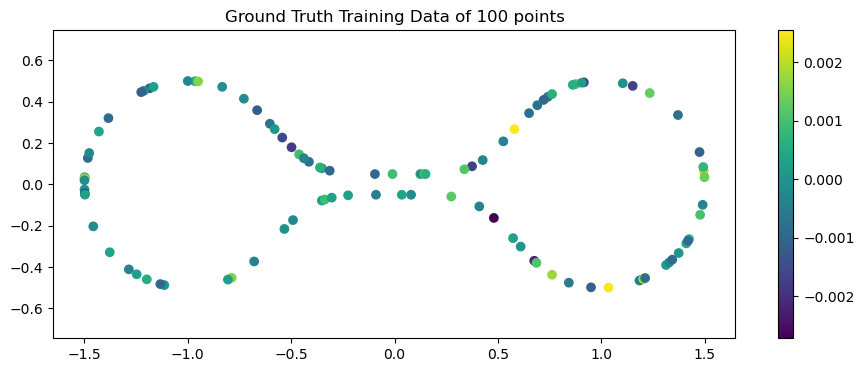

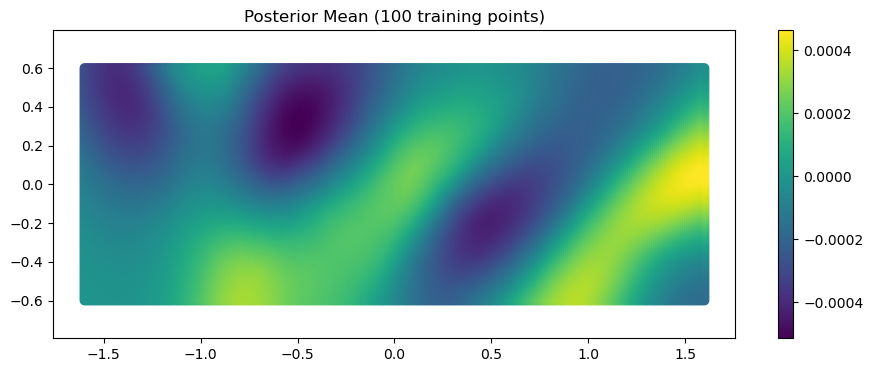

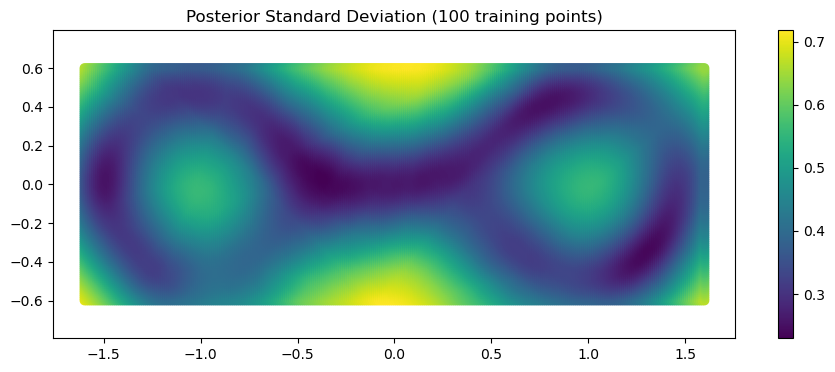

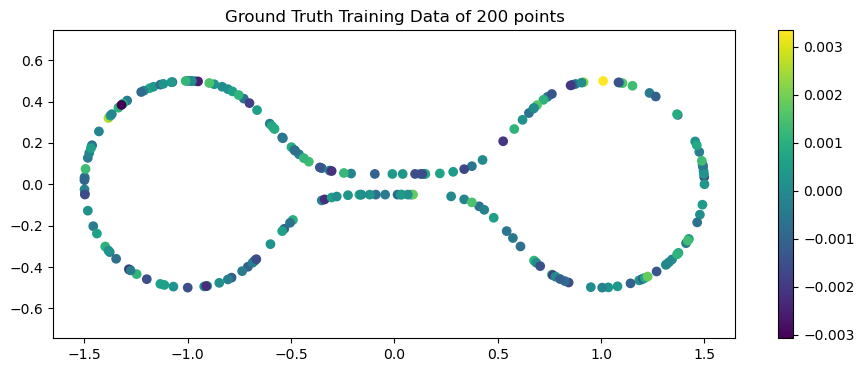

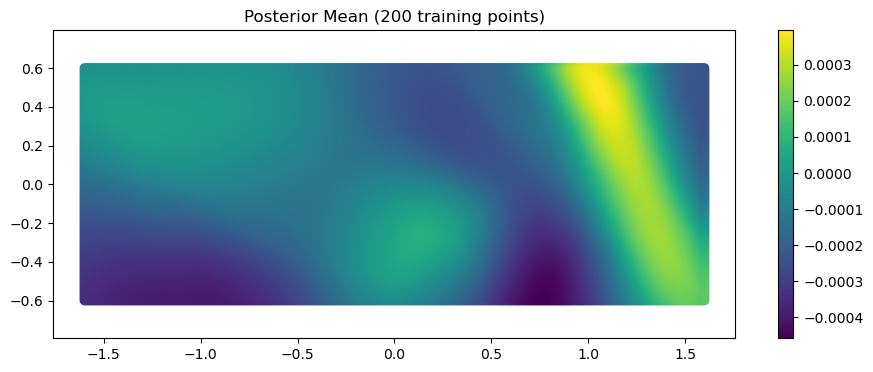

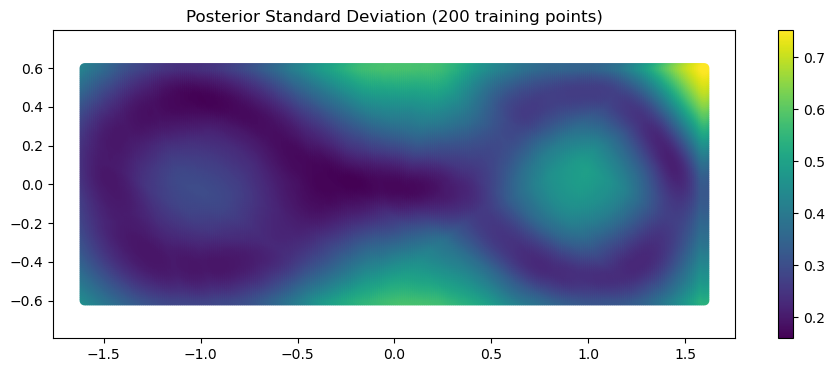

In [23]:
for nt in nums_train:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 2)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
    get_plot(nt, grid_preds, grid_points, test_y, model, posterior_only=True)

In [13]:
def show_contour(nt, predictions, test_x, model):
    posterior_mean = predictions.mean.cpu().numpy().reshape(grid_sizes[0], grid_sizes[1])
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.contour(test_x.cpu().numpy()[:, 0].reshape(grid_sizes[0], grid_sizes[1]), test_x.cpu().numpy()[:, 1].reshape(grid_sizes[0], grid_sizes[1]), posterior_mean)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title(f'Posterior Mean ({nt} training points)')

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00032123122946359217


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00022971043654251844


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00020127005700487643


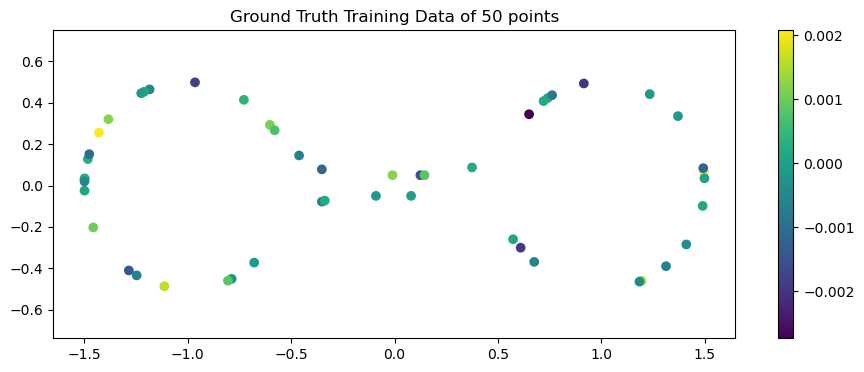

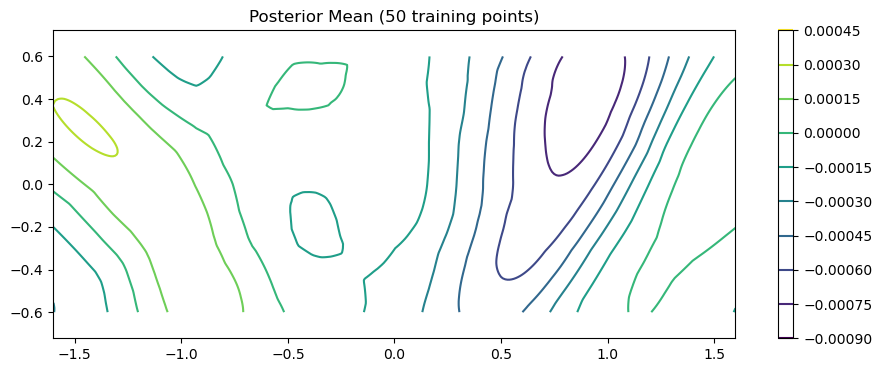

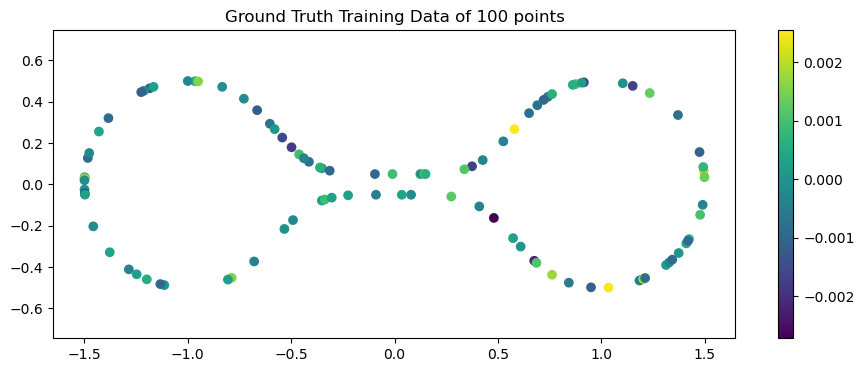

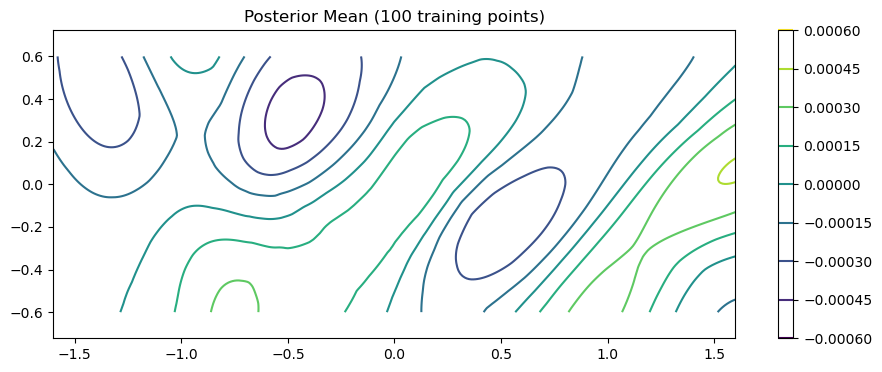

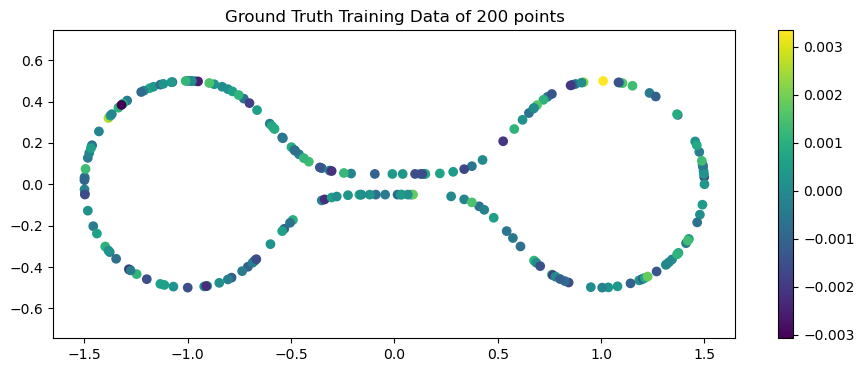

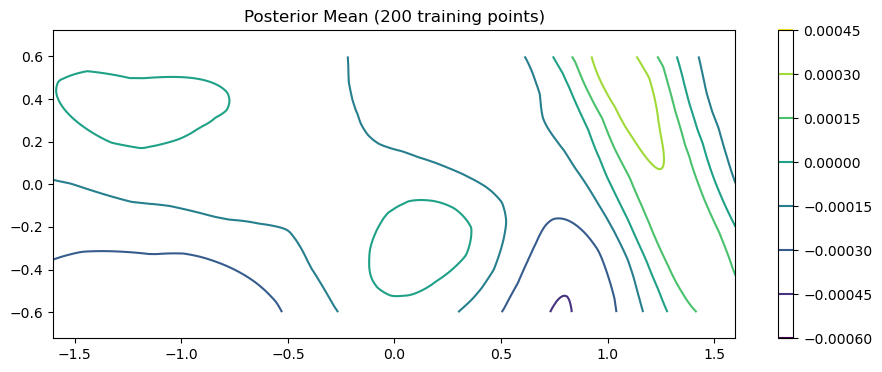

In [25]:
for nt in nums_train:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 2)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
    show_contour(nt, grid_preds, grid_points, model)

### Predicted Surface Comparison

In [14]:
def find_close_surface(nt, predictions, test_x, eps=0.00001):
    posterior_mean = predictions.mean
    posterior_std = predictions.stddev
    
    np_pred = posterior_mean.cpu().numpy()
    filtered_indices = np.where(np.logical_and(np_pred>-eps, np_pred<=eps))
    
    filtered_points = test_x[filtered_indices].cpu().numpy()
    filtered_mean = posterior_mean[filtered_indices].cpu().numpy()
    filtered_std = posterior_std[filtered_indices].cpu().numpy()
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(filtered_points[:, 0], filtered_points[:, 1], c=filtered_mean)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title(f'Posterior Mean from {nt} training points')

In [29]:
num_test = 500
nums_train2 = [100, 1000]

  0%|          | 0/10 [00:00<?, ?it/s]

Test RMSE: 0.00015405434533022344


  0%|          | 0/10 [00:00<?, ?it/s]

Test RMSE: 0.00010755429684650153


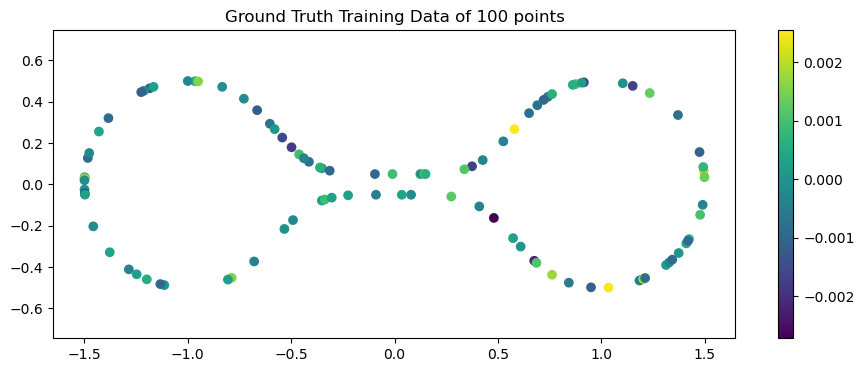

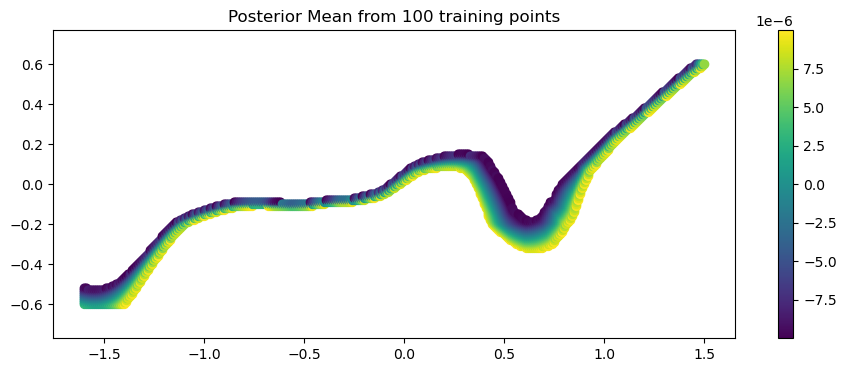

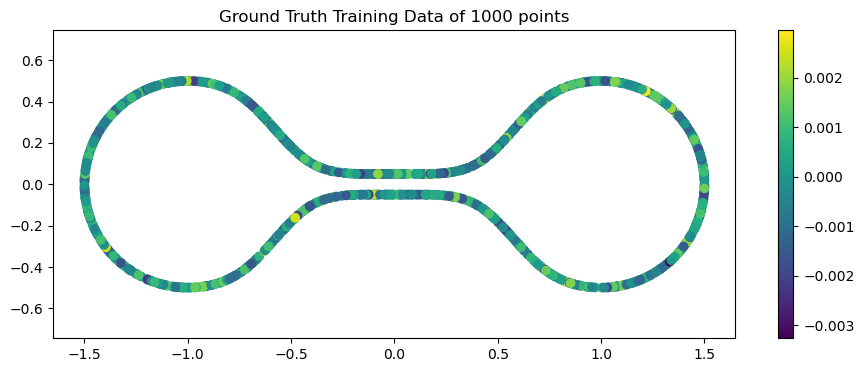

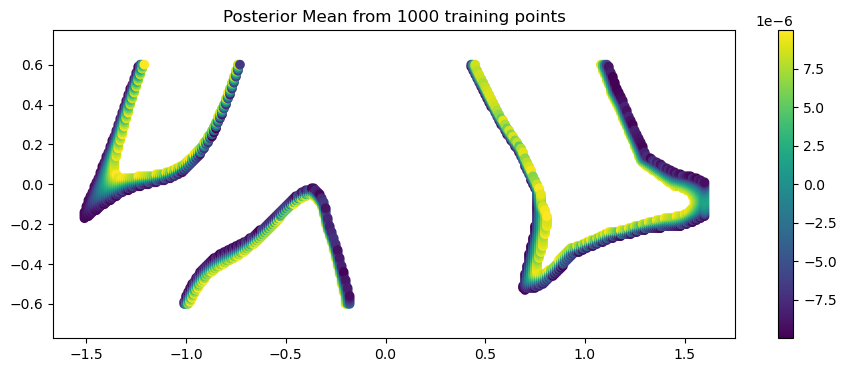

In [30]:
for nt in nums_train2:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 10)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
    find_close_surface(nt, grid_preds, grid_points)

### Binary Contour/ Occupany Function

In [38]:
def find_occupancy(nt, predictions, test_x):
    posterior_mean = predictions.mean
    posterior_std = predictions.stddev
    
    np_pred = posterior_mean.cpu().numpy()
    binary_pred = np_pred >= 0
    
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c=binary_pred)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title(f'Posterior Occupancy from Mean ({nt} training points)')

  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00016980685177259147


  0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE: 0.00011558900587260723


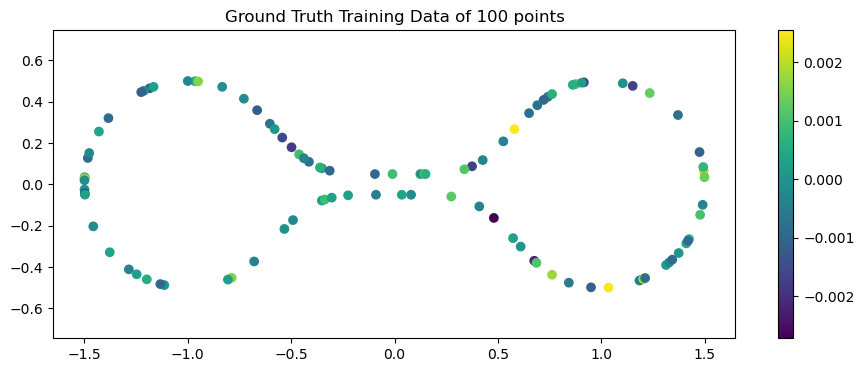

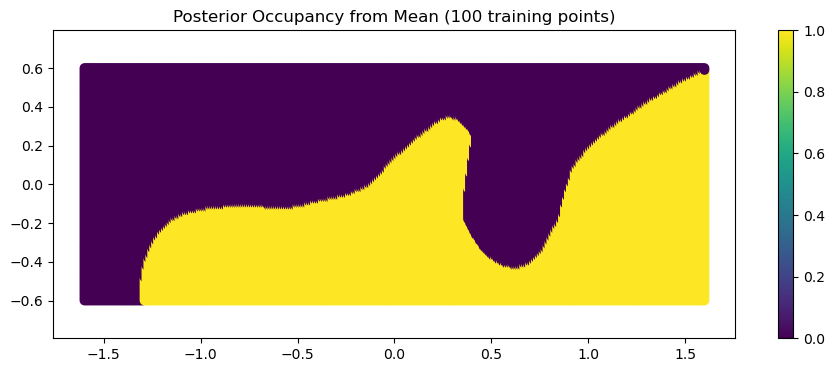

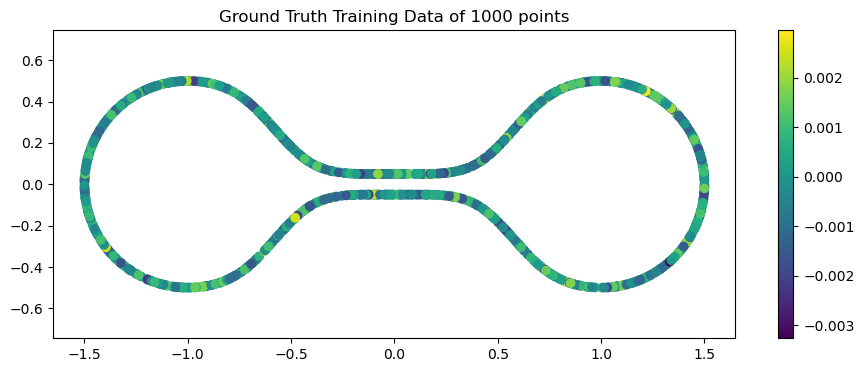

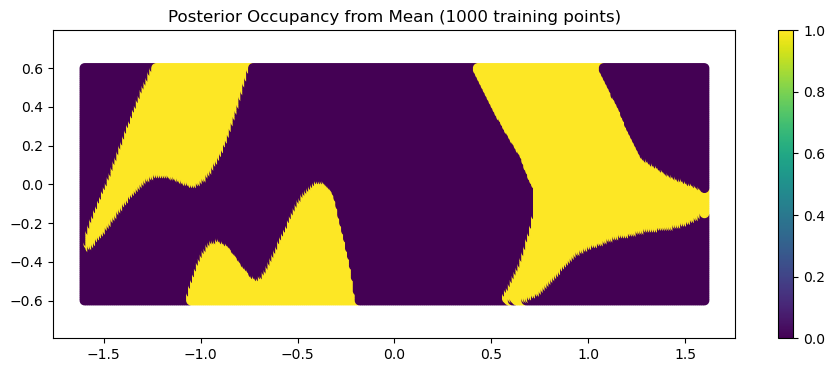

In [33]:
for nt in nums_train2:
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, nt, num_test, sampled_x, sampled_y)
    model, preds = get_result(train_x, train_y, test_x, test_y, 2)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
    find_occupancy(nt, grid_preds, grid_points)

## Covariance Function Learning

### Custom Neural Network Kernel

In [16]:
class NNKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = False

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

In [57]:
class NNStationaryCovar(torch.nn.Sequential):
    def __init__(self, input_data_dim):
        super(NNStationaryCovar, self).__init__()
        self.add_module('linear1', torch.nn.Linear(1, 32))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(32, 64))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(64, 32))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(32, 1))

# Polygon

TO SAMPLE FROM TWO SQUARE AREAS CONNECTED BY A RECTANGULAR CONNECTOR

In [53]:
def create_sq_rec(sq_side, rec_long_side, rec_short_side):
    diff = sq_side - rec_short_side
    assert diff > 0
    total_horizontal = (2 * sq_side) + rec_long_side
    left_x = - (total_horizontal / 2)
    bottom_y = - (sq_side / 2)
    right_x = -left_x
    top_y = -bottom_y
    samples = torch.empty((int(2* (total_horizontal + sq_side + diff) * 100), 2), dtype=torch.float32)
    samples_till_now = 0
    sq_sampl = int(100 * sq_side)
    for i in range(sq_sampl):
        samples[i + samples_till_now] = torch.Tensor([left_x, bottom_y + i/100.0])
        samples[i + samples_till_now + sq_sampl] = torch.Tensor([left_x + i/100.0, top_y])
        
    mid_sq_sampl = int(100 * diff/2)
    samples_till_now += 2*sq_sampl
    for j in range(mid_sq_sampl):
        samples[j + samples_till_now] = torch.Tensor([left_x + sq_side, top_y - j/100.0])
        
    rec_long_sampl = int(100 * rec_long_side)
    samples_till_now += mid_sq_sampl
    for k in range(rec_long_sampl):
        samples[k + samples_till_now] = torch.Tensor([left_x + sq_side + k/100.0, top_y - (diff/2)])
    
    samples_till_now += rec_long_sampl
    for j in range(mid_sq_sampl):
        samples[j + samples_till_now] = torch.Tensor([right_x - sq_side, top_y - (diff/2) + j/100.0])
    
    samples_till_now += mid_sq_sampl
    for i in range(sq_sampl):
        samples[i + samples_till_now] = torch.Tensor([right_x - sq_side + i/100.0, top_y])
        samples[i + samples_till_now + sq_sampl] = torch.Tensor([right_x, top_y - i/100.0])
        samples[i + samples_till_now + (2*sq_sampl)] = torch.Tensor([right_x - i/100.0, bottom_y])
    
    samples_till_now += (3*sq_sampl)
    for j in range(mid_sq_sampl):
        samples[j + samples_till_now] = torch.Tensor([right_x - sq_side, bottom_y + j/100.0])
        
    samples_till_now += mid_sq_sampl
    for k in range(rec_long_sampl):
        samples[k + samples_till_now] = torch.Tensor([right_x - sq_side - k/100.0, bottom_y + (diff/2)])
        
    samples_till_now += rec_long_sampl
    for j in range(mid_sq_sampl):
        samples[j + samples_till_now] = torch.Tensor([left_x + sq_side, bottom_y + (diff/2) - j/100.0])
        
    samples_till_now += mid_sq_sampl
    for i in range(sq_sampl):
        samples[i + samples_till_now] = torch.Tensor([left_x + sq_side - i/100.0, bottom_y])
    
    return samples

In [54]:
sample_10 = create_sq_rec(0.6, 0.8, 0.2)

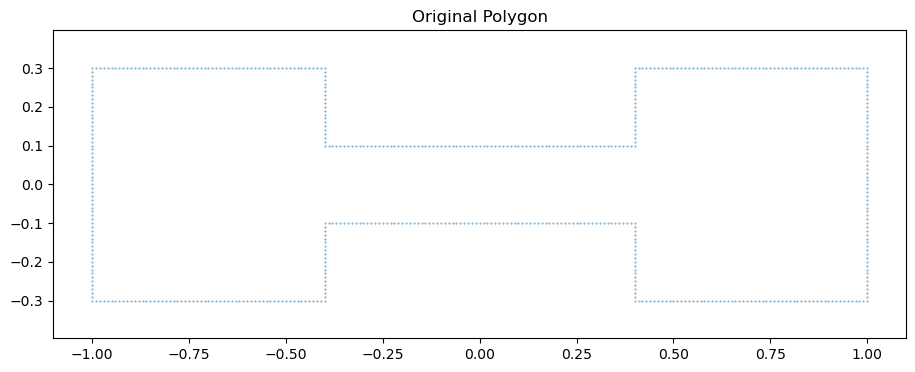

In [55]:
with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(sample_10.cpu().numpy()[:, 0], sample_10.cpu().numpy()[:, 1], s = 0.1)
        ax.axis('equal')
        ax.set_title(f'Original Polygon')

In [63]:
grid_points, grid_sizes = create_grid(sample_10, res=0.01, eps=0.2)
grid_points = grid_points.to(device)

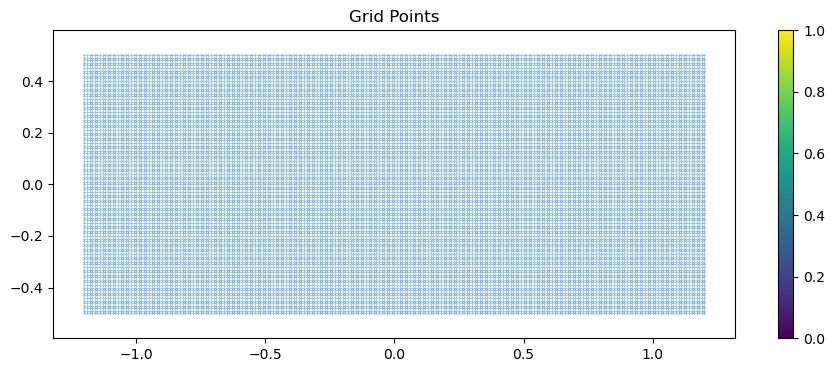

In [74]:
with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points')

In [66]:
pdist = torch.nn.PairwiseDistance(p=2)
def sdf_sq_rec(sq_side, rec_long_side, rec_short_side, pt):
    diff = sq_side - rec_short_side
    assert diff > 0
    total_horizontal = (2 * sq_side) + rec_long_side
    left_x = - (total_horizontal / 2)
    bottom_y = - (sq_side / 2)
    right_x = -left_x
    top_y = -bottom_y
    x, y = pt
    
    if x <= left_x or x >= right_x:
        if y >= bottom_y and y <= top_y:
            return min(torch.abs(x-left_x), torch.abs(x-right_x))
        elif y> top_y:
            return min(pdist(pt, torch.Tensor([left_x, top_y])), pdist(pt, torch.Tensor([right_x, top_y])))
        else:
            return min(pdist(pt, torch.Tensor([left_x, bottom_y])), pdist(pt, torch.Tensor([right_x, bottom_y])))
    elif x > left_x + sq_side and x < right_x - sq_side:
        if y > top_y:
            return min(pdist(pt, torch.Tensor([left_x+sq_side, top_y])), pdist(pt, torch.Tensor([right_x - sq_side, top_y])))
        elif y < bottom_y:
            return min(pdist(pt, torch.Tensor([left_x+sq_side, bottom_y])), pdist(pt, torch.Tensor([right_x - sq_side, bottom_y])))
        elif y>=rec_short_side/2 or y<=-rec_short_side/2:
            dist_x = min(torch.abs(x-left_x-sq_side), torch.abs(right_x-sq_side-x))
            dist_y = min(torch.abs(y - (rec_short_side/2)), torch.abs(y + (rec_short_side/2)))
            return min(dist_x, dist_y)
        else:
            return -min(torch.abs(y-bottom_y-(diff/2)), torch.abs(top_y-(diff/2)-y))
    else:
        if y > top_y:
            return y-top_y
        elif y < bottom_y:
            return bottom_y-y
        else:
            if x <= left_x + sq_side:
                le = left_x + sq_side
                if -(rec_short_side/2)<y<(rec_short_side/2):
                    dist_xy = min(x-left_x, y-bottom_y, top_y-y)
                    dist_left = min(pdist(pt, torch.Tensor([le, rec_short_side/2])), pdist(pt, torch.Tensor([le, -rec_short_side/2])))
                    return -min(dist_xy, dist_left)
                else:
                    dist_x = min(x-left_x, torch.abs(x-left_x-sq_side))
                    dist_y = min(y-bottom_y, top_y-y)
                    return -min(dist_x, dist_y)
            else:
                re = right_x - sq_side
                if -(rec_short_side/2)<y<(rec_short_side/2):
                    dist_xy = min(right_x-x, y-bottom_y, top_y-y)
                    dist_right = min(pdist(pt, torch.Tensor([re, rec_short_side/2])), pdist(pt, torch.Tensor([re, -rec_short_side/2])))
                    return -min(dist_xy, dist_right)
                else:
                    dist_x = min(torch.abs(x-right_x+sq_side), right_x-x)
                    dist_y = min(y-bottom_y, top_y-y)
                    return -min(dist_x, dist_y)    
                

In [67]:
sdf_grid = torch.empty(grid_points.size()[0], dtype=torch.float32)

In [68]:
for i in range(sdf_grid.size()[0]):
    sdf_grid[i] = sdf_sq_rec(0.6, 0.8, 0.2, grid_points[i])

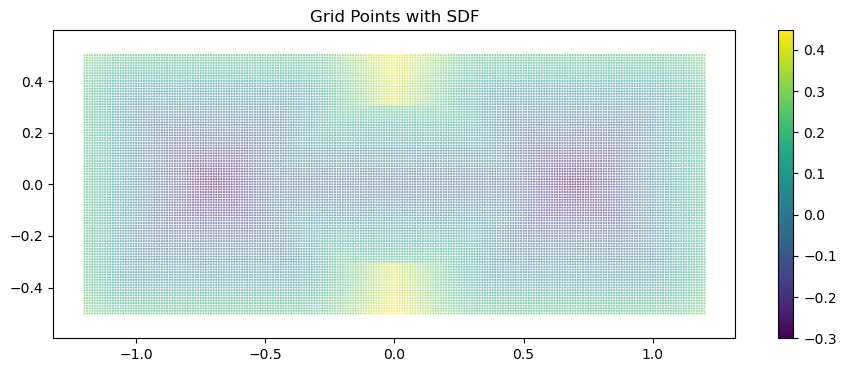

In [73]:
with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], c=sdf_grid.cpu().numpy(),s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points with SDF')

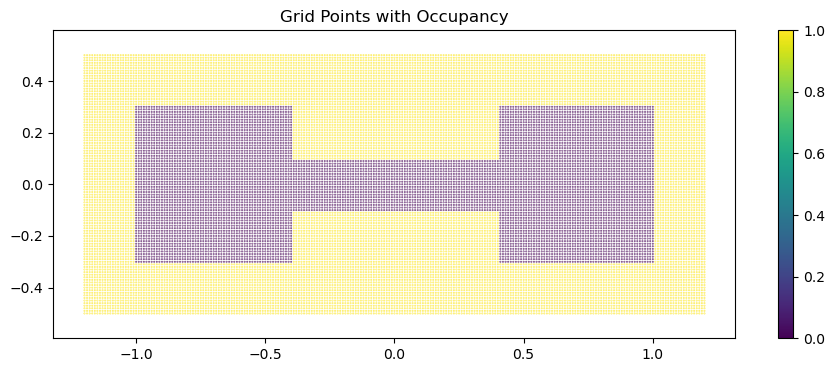

In [76]:
binary_sdf_grid = sdf_grid>0
with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], c=binary_sdf_grid.cpu().numpy(),s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points with Occupancy')

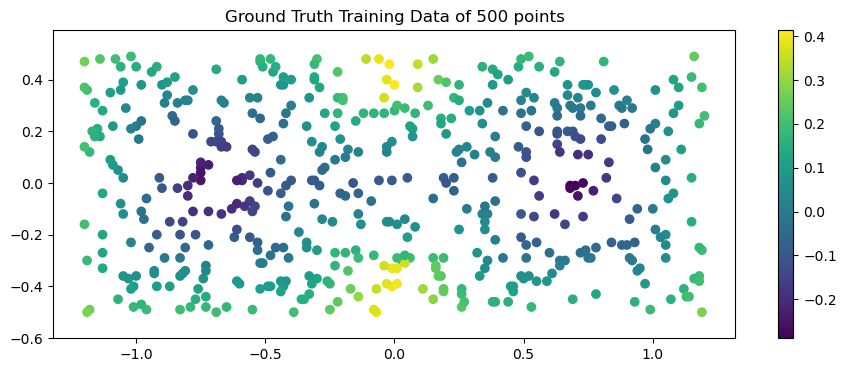

In [80]:
seed = 111
num_train = 500
num_test=10000
normalize_features = False
normalize_labels = False
train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_data(seed, num_train, num_test, grid_points, sdf_grid)

In [81]:
model, preds = get_result(train_x, train_y, test_x, test_y, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Test RMSE: 0.05136733129620552


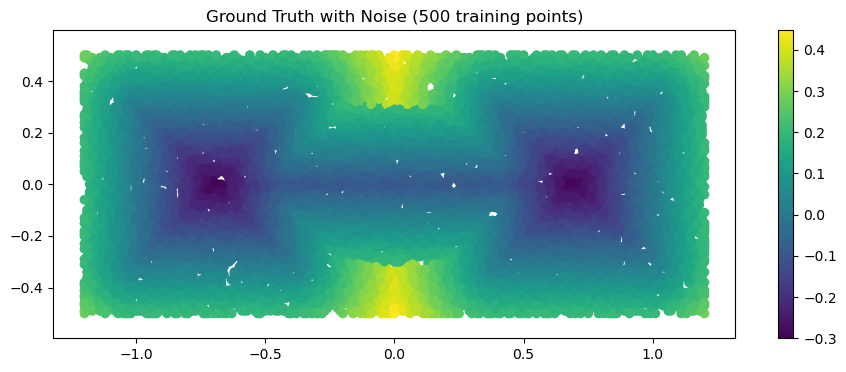

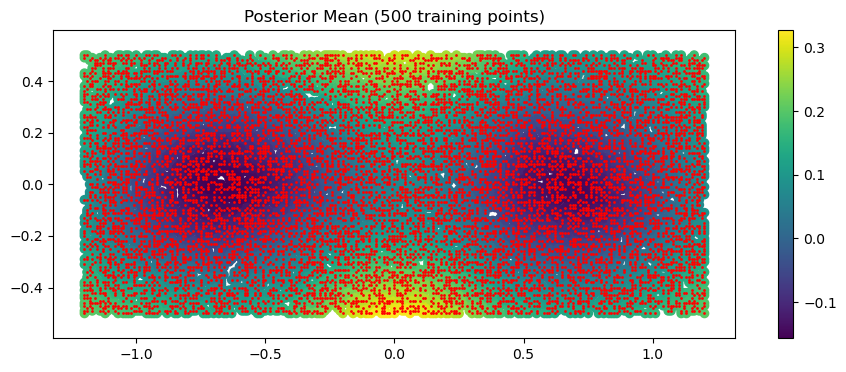

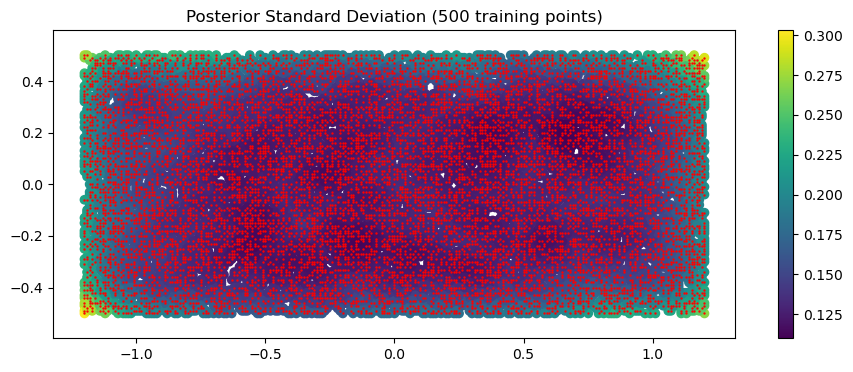

In [82]:
get_plot(num_train, preds, test_x, test_y, model)

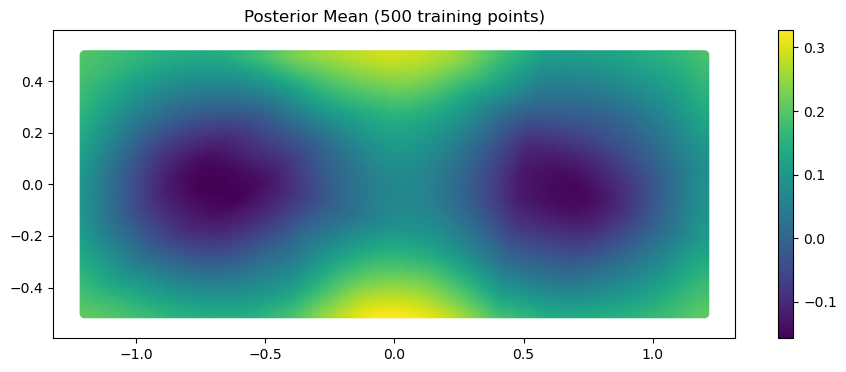

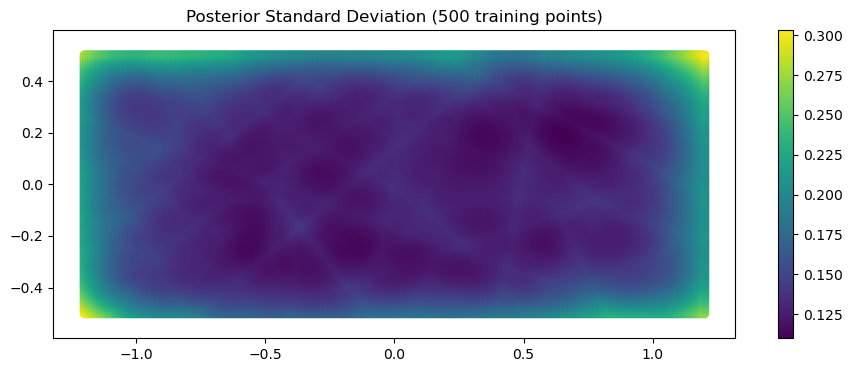

In [83]:
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
get_plot(num_train, grid_preds, grid_points, test_y, model, posterior_only=True)

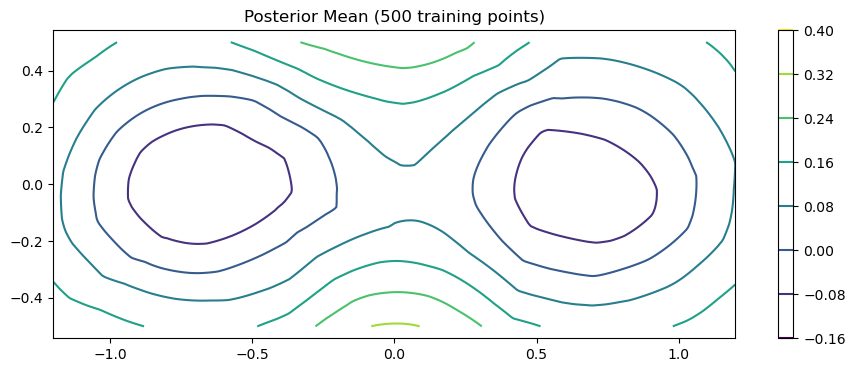

In [84]:
show_contour(num_train, grid_preds, grid_points, model)

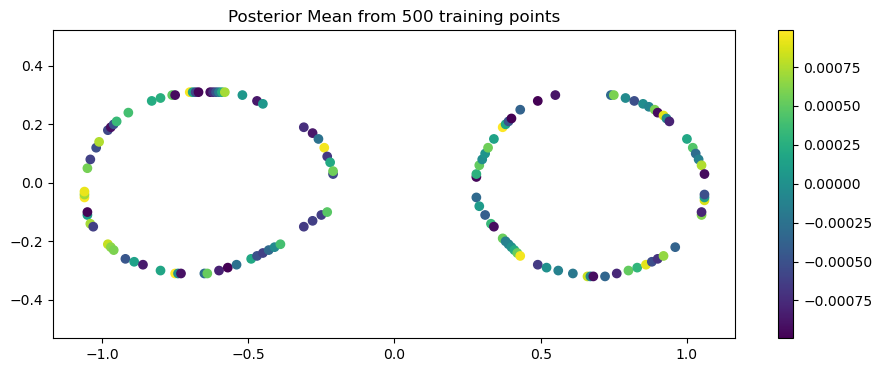

In [85]:
find_close_surface(num_train, grid_preds, grid_points, 0.001)

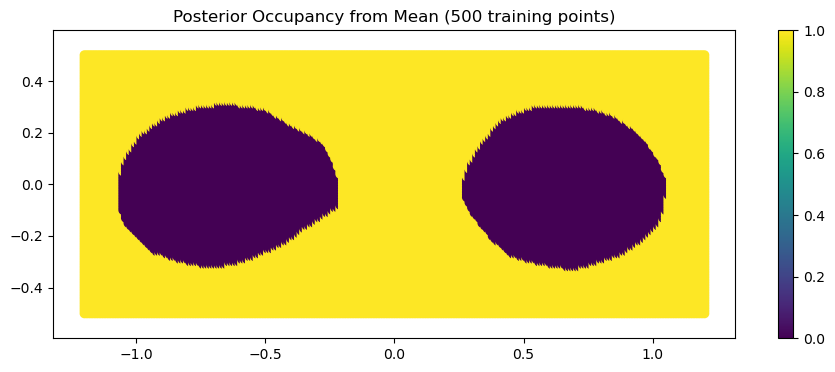

In [86]:
find_occupancy(num_train, grid_preds, grid_points)

### Surface with variance

In [40]:
from scipy.stats import norm

In [93]:
prob_out =  1 - norm.cdf(grid_preds.mean,0,grid_preds.stddev)

Text(0.5, 1.0, 'Probability of being inside the surface')

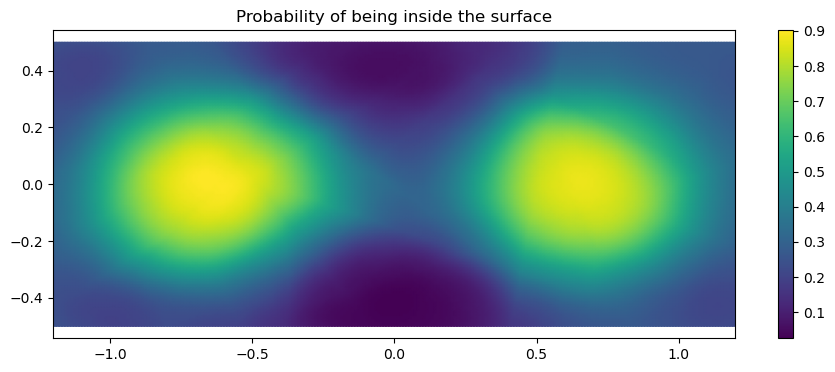

In [103]:
gp = grid_points.cpu().numpy()

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(gp[:, 0].reshape(grid_sizes.numpy()), gp[:, 1].reshape(grid_sizes.numpy()), prob_out.reshape(grid_sizes.numpy()), shading='gouraud',cmap='viridis')
fig.colorbar(plot)
ax.axis('equal')
ax.set_title(f'Probability of being inside the surface')